# Phenotypic classification based on gene expression
Below are tree based (random forest) classification models for assignment of multiple phenotypes to expression samples (multi-label/multi-target classification).

In [10]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)


import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support,roc_auc_score
from skmultilearn.model_selection import IterativeStratification
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.preprocessing as pp
import altair as alt
#alt.renderers.enable('notebook')
from IPython.display import display
import scipy.stats as ss
import matplotlib.pyplot as plt 
from sklearn.metrics import make_scorer
import seaborn as sb
from sklearn.utils.class_weight import compute_class_weight

from networks.functionsDENet import loadPickle,savePickle
from stages_DE.stages_library import PHENOTYPES

In [2]:
proteus=True
if proteus:
    pathClassification = '/home/khrovatin/timeTrajectoriesNet/data/stages/classification/'
else:
    pathClassification = '/home/karin/Documents/timeTrajectories/data/stages/classification/'

Data was previoulsy split into training and test set (10%). For cross validation used below only the training set is used. The split was done so that it preserves proportions of individual labels in training and test set. 

Phenotype tag_spore was not modeled as it has only 3 samples. Nevertheless, its data is still used in modeling other target features (all labels are 0).

In [3]:
X_train, Y_train, X_test, Y_test = loadPickle(pathClassification + 'train_test.pkl')
order=loadPickle(pathClassification+'target_order.pkl')

In [4]:
class_weight=[]
labels=[0,1]
for class_idx in range(Y_train.shape[1]):
    label_weights=compute_class_weight('balanced',labels,Y_train[:,class_idx])
    class_weight.append(dict(zip(labels,label_weights)))

## Parameter selection

### Random parameter search
Random parameter search for N of trees (n_estimators), max_depth, min_samples_leaf (minimal number of samples in a leaf), and max_samples (proportion of samples used in tree). Five-fold cross validation is performed on each parameter combination, using a splitter that preserves fold-based proportion of the labels in all targets.

In [ ]:
# Random parameter search
split = IterativeStratification(n_splits=5, order=1)
clf = RandomForestClassifier(criterion='entropy',n_jobs=10,class_weight='balanced')
# Params dist for random search
param_dist={
'n_estimators':[20,50,100,150,200,500,1000],
'max_depth':[20,50,100,200,300,400,500,700,1000,1500],
'min_samples_leaf':[2,3,4,5],
'max_samples':ss.uniform(0.1,0.9),
}

# Scoring functions for random search
def F_score_macro(y_true, y_pred): return precision_recall_fscore_support(y_true, y_pred, average='macro') [2]
def precision_macro(y_true, y_pred): return precision_recall_fscore_support(y_true, y_pred, average='macro') [0]
def recall_macro(y_true, y_pred): return precision_recall_fscore_support(y_true, y_pred, average='macro') [1]

scoring = {'accuracy': 'accuracy', 'F_score_macro': make_scorer(F_score_macro),
           'precision_macro': make_scorer(precision_macro), 'recall_macro': make_scorer(recall_macro)}

random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_dist,
                                   n_iter=300, scoring=scoring,n_jobs=20,cv=split,refit=False)
random_search.fit(X_train, Y_train)
savePickle(pathClassification+'randomForestGridSearch0.pkl',random_search.cv_results_)

In [5]:
# Random search results
random_search=loadPickle(pathClassification+'randomForestGridSearch0.pkl')
df_results = { key:value for key,value in random_search.items() if key !='params'}
df_results=pd.DataFrame(df_results)

In [8]:
# Data for heatmap of parameters and performace metrics
param_cols=[]
for param in param_dist.keys():
    param_cols.append('param_'+param)
params_data=pd.DataFrame(pp.minmax_scale(df_results[param_cols]),columns=param_cols)

score_cols=[]
score_std_cols=[]
for score in scoring.keys():
    score_cols.append('mean_test_'+score)
    score_std_cols.append('std_test_'+score)
    
heatmap_data= pd.concat([params_data, df_results[score_cols]], axis=1).sort_values('mean_test_F_score_macro',ascending=False)

Visualisation of parameters (scaled to [0,1]) and mean quality metrics obtained with these parameters over all used random parameter combinations. The heatmap is sorted by mean F score across folds, with best results at the top. 

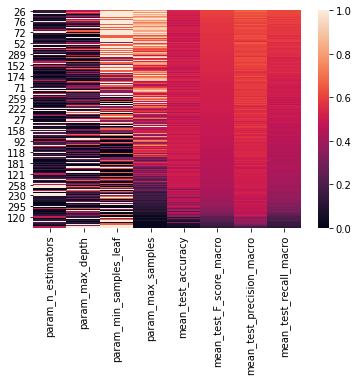

In [15]:
sb.heatmap(heatmap_data)

Results of 10 best parameter combinations based on mean F score across folds. 

In [12]:
df_results=df_results.sort_values('mean_test_F_score_macro',ascending=False)
df_results.head(10)[score_cols+score_std_cols+param_cols]

,mean_test_accuracy,mean_test_F_score_macro,mean_test_precision_macro,mean_test_recall_macro,std_test_accuracy,std_test_F_score_macro,std_test_precision_macro,std_test_recall_macro,param_n_estimators,param_max_depth,param_min_samples_leaf,param_max_samples
26,0.528472,0.618253,0.653309,0.638163,0.050420,0.044106,0.026885,0.089795,100,100,5,0.934082
182,0.540783,0.608463,0.659138,0.612043,0.068481,0.081798,0.076375,0.119872,150,700,4,0.822355
86,0.524062,0.607291,0.660751,0.616295,0.036260,0.038383,0.022442,0.088215,150,700,5,0.992255
244,0.519380,0.603175,0.646327,0.615929,0.032673,0.033805,0.066190,0.079926,150,1000,5,0.798695
21,0.520460,0.603067,0.623341,0.623871,0.040870,0.032990,0.059947,0.056088,500,50,5,0.981417
196,0.522710,0.599058,0.617363,0.618673,0.053965,0.062288,0.061981,0.087865,1000,700,5,0.987497
164,0.520112,0.597249,0.654009,0.607911,0.033755,0.050265,0.053781,0.097732,50,50,5,0.869901
31,0.499381,0.595812,0.627397,0.616280,0.054804,0.038003,0.058419,0.074313,50,400,5,0.948884
233,0.519028,0.593892,0.628927,0.605264,0.050757,0.049078,0.059333,0.092090,100,100,5,0.971428
54,0.518788,0.591756,0.622609,0.602410,0.038087,0.045949,0.054909,0.076226,200,700,5,0.783449


For min_samples_leaf and max_samples the choice of optimal value is straightforward (described below). For n_estimators an additional test will be performed below. Based on the top 10 results the max_depth does not seem to effect the results very much.  

Check mean F score of all random parameter combinations when using different max_depth values.  The below does not account for confounding effect of other parameters, but it shows that max_depth performs similarly at a wide range of parameter values. Thus a lower rather than higher max_depth was chosen. 

In [13]:
groupped=df_results.groupby('param_max_depth')['mean_test_F_score_macro']
for param_max_depth in df_results['param_max_depth'].sort_values().unique():
    data=groupped.get_group(param_max_depth)
    print('%-12s%-6.3f%-3s%-3.3f' % ('max_depth = '+str(param_max_depth)+': F_score ', data.mean(),'+-',data.sem()))

max_depth = 20: F_score 0.479 +- 0.014
max_depth = 50: F_score 0.496 +- 0.015
max_depth = 100: F_score 0.503 +- 0.015
max_depth = 200: F_score 0.445 +- 0.021
max_depth = 300: F_score 0.474 +- 0.016
max_depth = 400: F_score 0.469 +- 0.015
max_depth = 500: F_score 0.474 +- 0.018
max_depth = 700: F_score 0.505 +- 0.018
max_depth = 1000: F_score 0.497 +- 0.011
max_depth = 1500: F_score 0.456 +- 0.019


Choosen parameters: n_estimatros to be tested in range [40,600], max_depth=100, min_samples_leaf=5, max_samples=1.

### Selection of number of trees based on out of bag (OOB) error
The below code tracks the OOB error when adding additional trees to the forest.

In [16]:
clf = RandomForestClassifier(criterion='entropy', class_weight=class_weight,
                             max_depth=100,min_samples_leaf=5,max_samples=None, #max_samples None is 100% of samples
                             warm_start=True,oob_score=True)

error_rate=[]
features=[]
n_estimators_range=range(40, 601,5)
for n_estimators in n_estimators_range:
    #print(n_estimators)
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train, Y_train)
    oob_error = 1 - clf.oob_score_
    error_rate.append(oob_error)
    nonzero_feats=(clf.feature_importances_>0).sum()
    features.append(nonzero_feats)

Text(0, 0.5, 'N non null features')

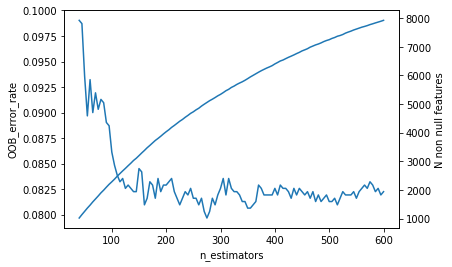

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(n_estimators_range,error_rate,label='OOB_error_rate')
ax1.set_ylabel('OOB_error_rate')
ax1.set_xlabel('n_estimators')
ax2.plot(n_estimators_range,features,label='N non null features')
ax2.set_ylabel('N non null features')

Selected value for n_estimators = 150.

## Forest for comparison with other classifiers
Constructs forests (with 5-fold cross validation) and measures thir performace to compare the tree based model with other classification models. 

In [18]:
prfs_all=pd.DataFrame()
rac_all=pd.DataFrame()
feats_all=pd.DataFrame()
split = IterativeStratification(n_splits=5, order=1)
fold=0
for train_index, test_index in split.split(X_train, Y_train):
    fold += 1
    print(fold)
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    Y_train_fold, Y_test_fold = Y_train[train_index], Y_train[test_index]
    classifier =RandomForestClassifier(criterion='entropy', class_weight='balanced',
                             max_depth=150,min_samples_leaf=5,max_samples=None,n_estimators=100
                            ).fit(X_train_fold,Y_train_fold)

    Y_predict_fold = classifier.predict(X_test_fold)
    Y_p_fold = classifier.predict_proba(X_test_fold)
    Y_p_fold_parsed=[]
    for class_idx in range(len(Y_p_fold)):
        label_idx=np.where(classifier.classes_[0] ==1)[0][0]
        Y_p_fold_parsed.append(Y_p_fold[class_idx][:,label_idx])
    Y_p_fold =np.array(Y_p_fold_parsed).T  
    
    prfs=pd.DataFrame(precision_recall_fscore_support(Y_test_fold, Y_predict_fold),index=['precision','recall','F_score','support']).T
    prfs['Stage']=order
    prfs_all=prfs_all.append(prfs)
    prfs=list(precision_recall_fscore_support(Y_test_fold, Y_predict_fold, average='micro'))
    prfs.append('all')
    prfs=dict(zip(['precision','recall','F_score','support','Stage'],prfs))
    prfs_all = prfs_all.append( prfs,ignore_index=True)
    rac=dict(zip(['roc_auc'],[ roc_auc_score(Y_test_fold, Y_p_fold, average='micro')]))
    rac_all=rac_all.append(rac,ignore_index=True)
    feats_all = feats_all.append({'Stage':'all','N_features':(classifier.feature_importances_>0).sum()},ignore_index=True)
savePickle(pathClassification+'randomForest.pkl',{'prfs':prfs_all,'rac':rac_all,'featsN':feats_all})

1
2
3
4


/home/khrovatin/miniconda3/envs/env1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5
